Found first hour of February in training data: 2025-02-01 00:00:00
Time interval between measurements: 0 days 01:00:00


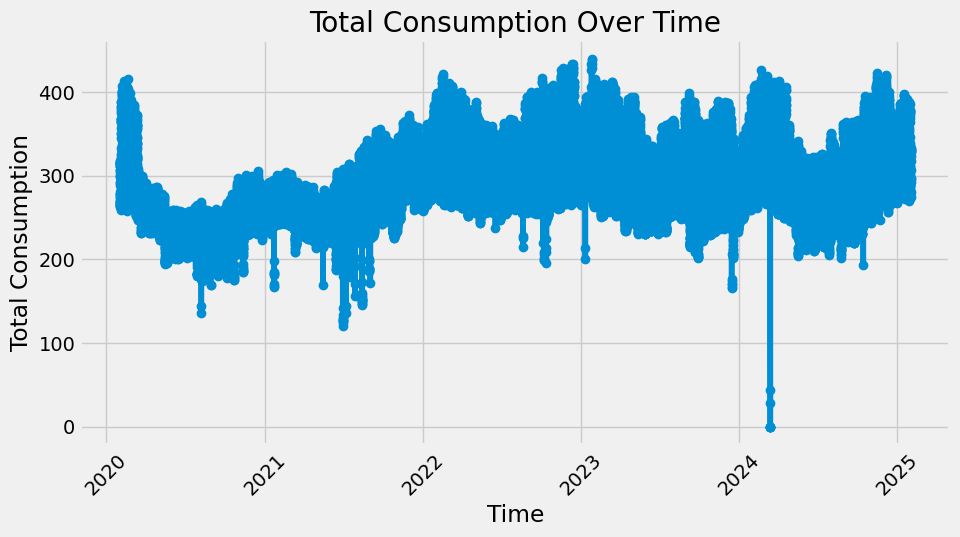

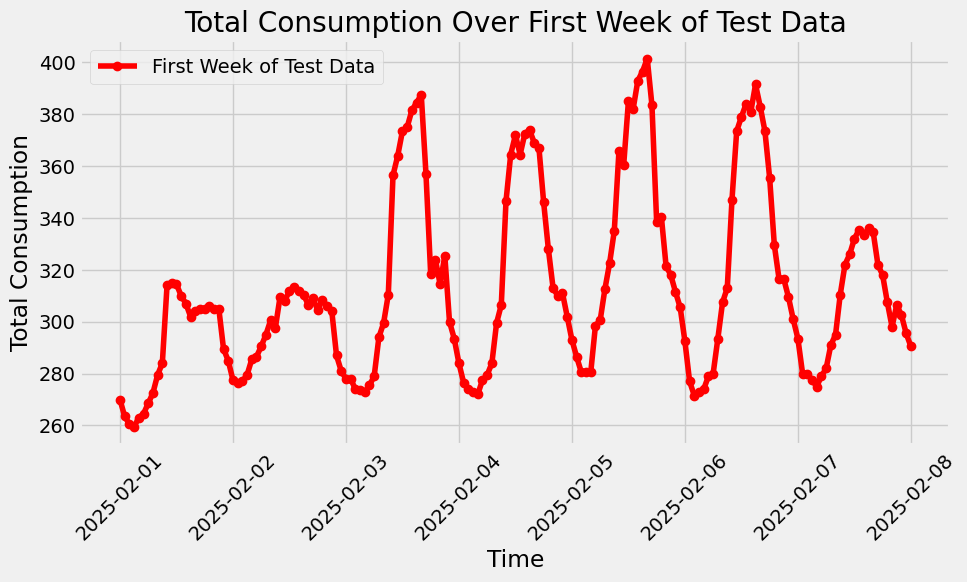

Expanded test data range: 2025-02-01 00:00:00 to 2025-02-28 23:00:00
         Interval End  Total Consumption
0 2025-02-01 00:00:00              270.0
1 2025-02-01 01:00:00              263.5
2 2025-02-01 02:00:00              260.5
3 2025-02-01 03:00:00              259.5
4 2025-02-01 04:00:00              263.0


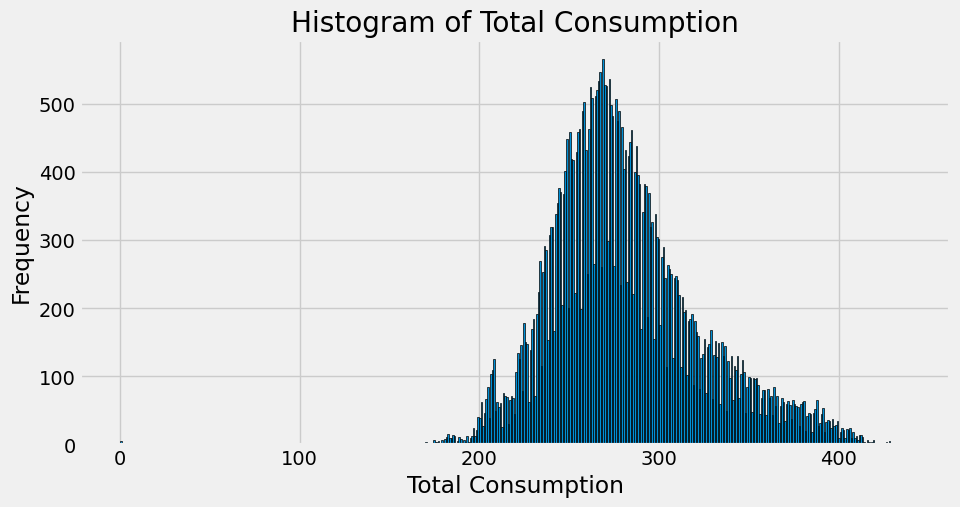

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Initial data loading and preprocessing before feature engineering

# Load the data, skipping the first row and setting correct column names
data = pd.read_excel(
    "data/Model Development Data_Shepard 2025.xlsx",
    skiprows=1,  # Skip the first row (header)
    names=["Interval End", "Meter1", "Meter2"]  # Set custom column names
)

# Load the test data
test_data_init = pd.read_excel(
    "data/Evaluation Data Students_Shepard 2025.xlsx",
    skiprows=1,  # Skip the first row (header)
    names=["Interval End", "Meter1", "Meter2"]  # Set custom column names
)

# Convert 'Interval End' to datetime
data['Interval End'] = pd.to_datetime(data['Interval End'])
test_data_init['Interval End'] = pd.to_datetime(test_data_init['Interval End'])

# Add total consumption
data['Total Consumption'] = data['Meter1'] + data['Meter2']
data = data.drop(columns=['Meter1', 'Meter2'])  # Drop the original meter columns

test_data_init['Total Consumption'] = test_data_init['Meter1'] + test_data_init['Meter2']
test_data_init = test_data_init.drop(columns=['Meter1', 'Meter2'])  # Drop the original meter columns

# Check if first hour of February exists in training data
february_start = pd.Timestamp("2025-02-01 00:00:00")
first_hour_record = data[data['Interval End'] == february_start]

# If the first hour of February exists in training data, move it to test data
if not first_hour_record.empty:
    print(f"Found first hour of February in training data: {first_hour_record.iloc[0]['Interval End']}")
    
    # Get the value we need to move
    first_hour_value = first_hour_record.iloc[0]['Total Consumption']
    
    # Remove it from training data
    data = data[data['Interval End'] != february_start]
    
    # Create or update the entry in test data
    if february_start in test_data_init['Interval End'].values:
        # Update existing record
        test_data_init.loc[test_data_init['Interval End'] == february_start, 'Total Consumption'] = first_hour_value
    else:
        # Create new record
        new_row = pd.DataFrame({'Interval End': [february_start], 'Total Consumption': [first_hour_value]})
        test_data_init = pd.concat([test_data_init, new_row], ignore_index=True)

# Sort test data by timestamp
test_data_init = test_data_init.sort_values(by="Interval End")

# Determine time interval between measurements
time_diff = test_data_init['Interval End'].diff().dropna().mode()[0]  # Most common time difference
print(f"Time interval between measurements: {time_diff}")

# Generate full range of timestamps for the entire month of February 2025 (28 days)
full_time_range = pd.date_range(
    start="2025-02-01 00:00:00",  # Start of February 2025
    end="2025-02-28 23:00:00",  # End of February 2025
    freq=time_diff  # Ensure the same frequency as the original data
)

# Create a complete test DataFrame with all timestamps for February
test_data = pd.DataFrame({"Interval End": full_time_range})

# Merge the original test data with the complete time range to ensure no missing timestamps
test_data = pd.merge(test_data, test_data_init, on="Interval End", how="left")

# Plotting the training data
plt.figure(figsize=(10, 5))
plt.plot(data['Interval End'], data['Total Consumption'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Total Consumption')
plt.title('Total Consumption Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plotting the first week of test data (February 1 to 7)
first_week_end = pd.Timestamp("2025-02-08 23:00")
first_week_data = test_data[(test_data['Interval End'] >= test_data['Interval End'].min()) & 
                             (test_data['Interval End'] <= first_week_end)]

plt.figure(figsize=(10, 5))
plt.plot(first_week_data['Interval End'], first_week_data['Total Consumption'], marker='o', linestyle='-', color='red', label="First Week of Test Data")
plt.xlabel('Time')
plt.ylabel('Total Consumption')
plt.title('Total Consumption Over First Week of Test Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Print expanded test data range and first few rows
print("Expanded test data range:", test_data['Interval End'].min(), "to", test_data['Interval End'].max())
print(test_data.head())


# Plot histogram of Total Consumption
plt.figure(figsize=(10, 5))
data['Total Consumption'].plot(kind='hist', bins=500, edgecolor='black')
plt.xlabel('Total Consumption')
plt.ylabel('Frequency')
plt.title('Histogram of Total Consumption')
plt.grid(True)
plt.show()

# # Plot outliers with dates using the index
# plt.figure(figsize=(15, 5))
# data.query('`Total Consumption` < 150')['Total Consumption'].plot(
#     style='.', 
#     color=color_pal[5], 
#     title='Outliers',
#     xlabel='Date'  # 'Date' is the label for the x-axis
# )
# plt.tight_layout()
# plt.show()

# # Remove outliers (overwrite original 'data' variable)
# data = data.query('`Total Consumption` >= 150')  # <-- Overwrite here

# # Plot cleaned data (USE INDEX FOR DATETIME)
# plt.figure(figsize=(10, 5))
# plt.plot(data.index, data['Total Consumption'],  # <-- Key fix: use .index
#          marker='o', linestyle='-', markersize=2)
# plt.xlabel('Time')
# plt.ylabel('Total Consumption')
# plt.title('Total Consumption Over Time (Cleaned Data)')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


# Read CCNY closed days from CSV
closed_days_df = pd.read_excel("data/CCNY CLOSED DAYS.xlsx")
closed_dates = pd.to_datetime(closed_days_df['Holidays'], format='%m/%d/%Y').dt.date
closed_dates_set = set(closed_dates)

# Load the natural gas prices
gas_data = pd.read_csv("data/Natural Gas (Henry Hub).csv")
gas_data['Date'] = pd.to_datetime(gas_data['Date'], format='%m/%d/%y').dt.date

# Filter gas data for the required date ranges
train_gas_data = gas_data[gas_data['Date'] <= pd.to_datetime('01/31/2025').date()]
test_gas_data = gas_data[(gas_data['Date'] >= pd.to_datetime('02/01/2025').date()) & 
                         (gas_data['Date'] <= pd.to_datetime('02/28/2025').date())]

# Load and combine weather data (training)
weather1 = pd.read_csv("data/Weather data 2020-02-01 to 2022-10-01.csv")
weather2 = pd.read_csv("data/Weather data 2022-10-02 to 2025-01-31.csv")
weather = pd.concat([weather1, weather2], axis=0)

# Verify columns exist before selection
required_columns = ['datetime', 'temp', 'humidity', 'solarradiation']
assert all(col in weather.columns for col in required_columns), "Missing columns in weather data"

# Process weather data (training)
weather = weather[required_columns].copy()
weather['Date'] = pd.to_datetime(weather['datetime'], errors='coerce').dt.date
weather = weather.drop(columns=['datetime'])
weather = weather.groupby('Date').first().reset_index()  # Ensure one row per date

# Load test weather data
weather_test = pd.read_csv("data/Weather_Test_correct.csv")
weather_test = weather_test[required_columns].copy()
weather_test['Interval End'] = pd.to_datetime(weather_test['datetime'], errors='coerce')
weather_test = weather_test.drop(columns=['datetime'])

# Prepare training energy data for merging (add Date column)
data['Date'] = data['Interval End'].dt.date

# Merge weather data with training data
train_data = pd.merge(
    data,
    weather,
    on='Date',
    how='left'
)

# Prepare test energy data for merging
test_data['Date'] = test_data['Interval End'].dt.date

# Merge on EXACT HOURLY TIMESTAMPS for test data
test_data = pd.merge(
    test_data,
    weather_test,
    on='Interval End',
    how='left'
)

# Merge natural gas prices with training and test data
train_data = pd.merge(train_data, train_gas_data[['Date', 'Close']], how='left', on='Date')
test_data = pd.merge(test_data, test_gas_data[['Date', 'Close']], how='left', on='Date')

# Forward-fill and backward-fill missing gas price values
train_data['Close'] = train_data['Close'].ffill()
train_data['Close'] = train_data['Close'].bfill()
test_data['Close'] = test_data['Close'].ffill()
test_data['Close'] = test_data['Close'].bfill()

# Forward-fill weather columns
weather_cols = ['temp', 'humidity', 'solarradiation']
train_data[weather_cols] = train_data[weather_cols].ffill()
test_data[weather_cols] = test_data[weather_cols].ffill()

# Function to assign DayType
def get_day_type(date):
    day_of_week = date.weekday()
    if date in closed_dates_set:
        return 4  # Closed day
    elif day_of_week == 4:  # Friday
        return 2
    elif day_of_week in [5, 6]:  # Weekend (Sat-Sun)
        return 3
    else:
        return 1  # Monday-Thursday

# Enhanced peak categorization based on actual load profiles
def enhanced_categorize_peak(hour, day_type, month):
    # Different seasons have different peak patterns
    is_heating_season = month in [1, 2, 3, 11, 12]  # Winter months
    is_cooling_season = month in [6, 7, 8, 9]  # Summer months
    is_shoulder_season = month in [4, 5, 10]  # Spring/Fall
    
    # Weekend/holiday pattern (from data: lower overall consumption, flatter curve)
    if day_type in [3, 4]:  # Weekends & Closed Days
        if is_heating_season:
            if 9 <= hour < 20:  # Extended daytime period
                return 1.0  # Moderate Peak
            elif 0 <= hour < 7 or 22 <= hour < 24:
                return 0.2  # Deep Off-Peak
            else:
                return 0.6  # Transition
        elif is_cooling_season:
            if 10 <= hour < 22:  # Longer summer peak
                return 1.2  # Summer Weekend Peak
            else:
                return 0.3  # Summer Night Off-Peak
        else:  # Shoulder season
            if 9 <= hour < 19:
                return 0.8  # Shoulder Season Peak
            else:
                return 0.3  # Shoulder Season Off-Peak
    
    # Friday pattern (transitional day)
    elif day_type == 2:  # Friday
        if is_heating_season:
            if 8 <= hour < 12:  # Morning ramp
                return 1.6  # Morning Peak
            elif 12 <= hour < 16:  # Midday peak
                return 2.0  # Full Peak
            elif 16 <= hour < 21:  # Evening decline
                return 1.4  # Evening Transition  
            else:
                return 0.3  # Night Off-Peak
        elif is_cooling_season:
            if 8 <= hour < 18:
                return 2.1  # Summer Peak (longer duration)
            elif 18 <= hour < 22:
                return 1.5  # Summer Evening
            else:
                return 0.4  # Summer Night
        else:  # Shoulder season
            if 8 <= hour < 17:
                return 1.7  # Shoulder Day Peak
            elif 17 <= hour < 21:
                return 1.2  # Shoulder Evening
            else:
                return 0.3  # Shoulder Night
    
    # Weekday pattern (Monday-Thursday) - showing strongest peaks
    else:
        if is_heating_season:
            if 8 <= hour < 10:  # Morning ramp
                return 1.7  # Morning Ramp
            elif 10 <= hour < 17:  # Midday peak (matches data showing peak 11AM-4PM)
                return 2.5  # Critical Peak
            elif 17 <= hour < 21:  # Evening decline
                return 1.5  # Evening Transition
            else:
                return 0.3  # Night Off-Peak
        elif is_cooling_season:
            if 8 <= hour < 18:
                return 2.7  # Summer Critical Peak
            elif 18 <= hour < 22:
                return 1.6  # Summer Evening
            else:
                return 0.4  # Summer Night
        else:  # Shoulder season
            if 8 <= hour < 17:
                return 2.0  # Shoulder Day Peak
            elif 17 <= hour < 21:
                return 1.4  # Shoulder Evening
            else:
                return 0.3  # Shoulder Night

# Add basic temporal features
for df in [train_data, test_data]:
    df['Month'] = df['Interval End'].dt.month
    df['Hour'] = df['Interval End'].dt.hour
    df['DayType'] = df['Interval End'].dt.date.apply(get_day_type)
    df['Peak'] = df.apply(lambda row: enhanced_categorize_peak(row['Hour'], row['DayType'], row['Month']), axis=1)
    
    # Add Pandemic indicator
    pandemic_start = pd.to_datetime('2020-03-19')
    pandemic_end = pd.to_datetime('2021-08-28')
    df['Pandemic'] = ((df['Interval End'] >= pandemic_start) & (df['Interval End'] <= pandemic_end)).astype(int)
    
    # Extract week number in the year
    df['WeekOfYear'] = df['Interval End'].dt.isocalendar().week
    
    # Add day of the week (0=Monday to 6=Sunday)
    df['Day'] = df['Interval End'].dt.weekday
    
    # Create interaction column: Peak * Hour
    df['Peak_Hour_Interaction'] = df['Peak'] * df['Hour']
    
    # Create interaction column: Peak * Hour * Day
    df['Peak_Hour_Day_Interaction'] = df['Peak'] * df['Hour'] * df['Day']
    
    df['Day_Hour_Interaction'] = df['Day'] * df['Hour']

# Function to compute historical lag mean
def compute_historical_lag_mean(df):
    lag_intervals = [8736 * i for i in range(1, 6)]  # Lags at 1-year intervals for 5 years
    for i, lag in enumerate(lag_intervals):
        df[f'lag_{lag}'] = df['Total Consumption'].shift(lag)

    # Fill missing values according to the rule:
    for i, lag in enumerate(lag_intervals):
        if i == 0:  # First year (8736h ago)
            df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df['Total Consumption'])
        else:  # Other years
            df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df[f'lag_{lag_intervals[i-1]}'])

    # Compute historical average lag
    df['Historical_Avg_Lag'] = df[[f'lag_{lag}' for lag in lag_intervals]].mean(axis=1)

    # Drop the individual lag columns
    df.drop(columns=[f'lag_{lag}' for lag in lag_intervals], inplace=True)

    return df

# Apply historical lag to training data
train_data = compute_historical_lag_mean(train_data)

# Map Historical_Avg_Lag from training set to test set
historical_lag_map = train_data.groupby(['Month', 'DayType', 'Hour'])['Historical_Avg_Lag'].mean()
test_data['Historical_Avg_Lag'] = test_data.apply(
    lambda row: historical_lag_map.get((row['Month'], row['DayType'], row['Hour']), 
                                      historical_lag_map.mean()), 
    axis=1
)

# Drop 'Peak' and 'Date' columns as we've created better features
train_data.drop(columns=['Peak', 'Date'], inplace=True)
test_data.drop(columns=['Peak', 'Date'], inplace=True)

# Now we have the basic data processed, let's enhance the features

In [ ]:
def enhance_features(train_data, test_data):
    """
    Comprehensive feature engineering function for energy consumption forecasting
    """
    # Make copies to avoid warnings
    train_data = train_data.copy()
    test_data = test_data.copy()
    
    print("Starting feature engineering...")
    
    # Add cyclical temporal features
    for df in [train_data, test_data]:
        # Cyclical encoding of hour
        df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
        df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
        
        # Cyclical encoding of day of week
        df['day_sin'] = np.sin(2 * np.pi * df['Day']/7)
        df['day_cos'] = np.cos(2 * np.pi * df['Day']/7)
        
        # Cyclical encoding of month
        df['month_sin'] = np.sin(2 * np.pi * df['Month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['Month']/12)
        
        # Cyclical encoding of week of year
        df['week_sin'] = np.sin(2 * np.pi * df['WeekOfYear']/52)
        df['week_cos'] = np.cos(2 * np.pi * df['WeekOfYear']/52)
    
    print("Added cyclical time encoding features")
    
    # Categorical time features
    for df in [train_data, test_data]:
        # Season indicators
        df['is_winter'] = df['Month'].isin([12, 1, 2]).astype(int)
        df['is_spring'] = df['Month'].isin([3, 4, 5]).astype(int)
        df['is_summer'] = df['Month'].isin([6, 7, 8]).astype(int)
        df['is_fall'] = df['Month'].isin([9, 10, 11]).astype(int)
        
        # Day type indicators (expand on existing DayType feature)
        df['is_weekday'] = df['DayType'].isin([1, 2]).astype(int)
        df['is_weekend'] = df['DayType'].isin([3]).astype(int)
        df['is_holiday'] = df['DayType'].isin([4]).astype(int)
        
        # Start/end of week
        df['is_start_of_week'] = (df['Day'] == 0).astype(int)
        df['is_end_of_week'] = (df['Day'] == 4).astype(int)
        
        # Friday feature (special day pattern)
        df['is_friday'] = (df['Day'] == 4).astype(int)
    
    print("Added categorical time features")
    
    # Time of day features
    for df in [train_data, test_data]:
        # Business hours flag (9am-5pm on weekdays)
        df['is_business_hours'] = ((df['Hour'] >= 9) & 
                                  (df['Hour'] < 17) & 
                                  (df['is_weekday'] == 1)).astype(int)
        
        # Peak hour identification (morning and evening peaks)
        df['is_morning_peak'] = ((df['Hour'] >= 7) & 
                                (df['Hour'] < 10) & 
                                (df['is_weekday'] == 1)).astype(int)
        
        df['is_evening_peak'] = ((df['Hour'] >= 17) & 
                                (df['Hour'] < 21) & 
                                (df['is_weekday'] == 1)).astype(int)
        
        # Transitions (ramp periods before/after peaks)
        df['is_pre_morning_peak'] = ((df['Hour'] >= 5) & 
                                    (df['Hour'] < 7) & 
                                    (df['is_weekday'] == 1)).astype(int)
        
        df['is_post_morning_peak'] = ((df['Hour'] >= 10) & 
                                     (df['Hour'] < 12) & 
                                     (df['is_weekday'] == 1)).astype(int)
        
        df['is_pre_evening_peak'] = ((df['Hour'] >= 15) & 
                                    (df['Hour'] < 17) & 
                                    (df['is_weekday'] == 1)).astype(int)
        
        df['is_post_evening_peak'] = ((df['Hour'] >= 21) & 
                                     (df['Hour'] < 23) & 
                                     (df['is_weekday'] == 1)).astype(int)
        
        # Any peak hour
        df['is_any_peak'] = ((df['is_morning_peak'] == 1) | 
                            (df['is_evening_peak'] == 1)).astype(int)
        
        # Any transition hour
        df['is_any_transition'] = ((df['is_pre_morning_peak'] == 1) | 
                                  (df['is_post_morning_peak'] == 1) | 
                                  (df['is_pre_evening_peak'] == 1) | 
                                  (df['is_post_evening_peak'] == 1)).astype(int)
        
        # Night transition periods
        df['is_night_transition'] = ((df['Hour'] >= 22) | 
                                    (df['Hour'] < 5)).astype(int)
        
        # Day transition periods
        df['is_day_transition'] = ((df['Hour'] >= 5) & 
                                  (df['Hour'] < 9)).astype(int)
        
        # Weekend daytime
        df['weekday_business_hours'] = ((df['Hour'] >= 9) & 
                                       (df['Hour'] < 17) & 
                                       (df['is_weekday'] == 1)).astype(int)
        
        # Weekend daytime
        df['weekend_daytime'] = ((df['Hour'] >= 9) & 
                                (df['Hour'] < 17) & 
                                (df['is_weekend'] == 1)).astype(int)
        
        # Holiday specific effects 
        df['friday_evening'] = ((df['Hour'] >= 17) & 
                               (df['Hour'] < 21) & 
                               (df['is_friday'] == 1)).astype(int)
    
    print("Added time of day features")
    
    # Load pattern features (based on hour time periods)
    hour_categories = {
        'hour_morning_ramp': [5, 6, 7, 8],
        'hour_midday_peak': [9, 10, 11, 12, 13, 14, 15, 16],
        'hour_afternoon_trans': [17, 18, 19, 20],
        'hour_night_offpeak': [21, 22, 23, 0, 1, 2, 3, 4]
    }
    
    # Create hour category flags
    for df in [train_data, test_data]:
        for name, hours in hour_categories.items():
            df[name] = df['Hour'].isin(hours).astype(int)
    
    # Create day-specific hour category flags
    for df in [train_data, test_data]:
        for day_type in [1, 2, 3, 4]:  # DayType categories
            for name, hours in hour_categories.items():
                interaction_name = f'daytype{day_type}_{name}'
                df[interaction_name] = ((df['DayType'] == day_type) & 
                                       df['Hour'].isin(hours)).astype(int)
    
    print("Added load pattern features")
    
    # Enhanced weather features
    for df in [train_data, test_data]:
        # Temperature range categorization
        df['temp_range_freezing'] = (df['temp'] < 32).astype(int)
        df['temp_range_cold'] = ((df['temp'] >= 32) & (df['temp'] < 45)).astype(int)
        df['temp_range_cool'] = ((df['temp'] >= 45) & (df['temp'] < 60)).astype(int)
        df['temp_range_mild'] = ((df['temp'] >= 60) & (df['temp'] < 70)).astype(int)
        df['temp_range_warm'] = ((df['temp'] >= 70) & (df['temp'] < 80)).astype(int)
        df['temp_range_hot'] = (df['temp'] >= 80).astype(int)
        
        # Temperature extremes
        df['is_extreme_cold'] = (df['temp'] < 20).astype(int)
        df['is_extreme_hot'] = (df['temp'] > 90).astype(int)
        
        # Humidity ranges
        df['is_low_humidity'] = (df['humidity'] < 30).astype(int)
        df['is_high_humidity'] = (df['humidity'] > 70).astype(int)
        
        # Heat index (temperature and humidity interaction)
        df['heat_index'] = df['temp'] * (1 + 0.01 * df['humidity'])
        
        # Comfort index (simplified version)
        df['comfort_index'] = abs(df['temp'] - 70) + 0.5 * df['humidity']
        
        # Temperature comfort deviation from ideal (70°F)
        df['temp_comfort_deviation'] = abs(df['temp'] - 70)
        
        # Solar radiation ranges
        df['solar_low'] = (df['solarradiation'] < 200).astype(int)
        df['solar_medium'] = ((df['solarradiation'] >= 200) & 
                             (df['solarradiation'] < 600)).astype(int)
        df['solar_high'] = (df['solarradiation'] >= 600).astype(int)
        
        # Interaction: temperature and solar radiation
        df['temp_solar_interaction'] = df['temp'] * df['solarradiation'] / 1000  # Scaled
    
    print("Added enhanced weather features")
    
    # Temperature-hour interaction features
    # Create temperature quartiles (0-25%, 25-50%, 50-75%, 75-100%)
    train_temp_quantiles = train_data['temp'].quantile([0.25, 0.5, 0.75]).values
    
    # Use the training data quantiles for both datasets for consistency
    for df in [train_data, test_data]:
        # Create temp_quartile column
        df['temp_quartile'] = pd.cut(
            df['temp'], 
            bins=[-float('inf')] + list(train_temp_quantiles) + [float('inf')],
            labels=[0, 1, 2, 3]
        ).astype(int)
        
        # Group hours into blocks
        hour_blocks = [
            (0, 3), (3, 6), (6, 9), (9, 12),
            (12, 15), (15, 18), (18, 21), (21, 24)
        ]
        
        # Create temperature-hour interactions
        for temp_q in range(4):
            for start_h, end_h in hour_blocks:
                col_name = f'temp{temp_q*25}_{(temp_q+1)*25}_hour{start_h}_{end_h}'
                df[col_name] = (
                    
                    (df['temp_quartile'] == temp_q) & 
                    (df['Hour'] >= start_h) & 
                    (df['Hour'] < end_h)
                ).astype(int)
    
    print("Added temperature-hour interaction features")
    
    # Enhanced gas price features
    for df in [train_data, test_data]:
        # Normalize gas price relative to its mean and std over past year
        # First calculate the mean and std from the training data
        gas_mean = train_data['Close'].mean()
        gas_std = train_data['Close'].std()
        
        # Apply normalization to both datasets
        df['gas_price_normalized'] = (df['Close'] - gas_mean) / gas_std
        
        # Gas price trend indicators
        df['gas_price_above_trend'] = (df['gas_price_normalized'] > 0.5).astype(int)
        df['gas_price_below_trend'] = (df['gas_price_normalized'] < -0.5).astype(int)
        
        # Monthly aggregated gas price metrics
        df['gas_price_avg'] = df.groupby(['Month'])['Close'].transform('mean')
        
        # Monthly ranking of gas prices (percentile within month)
        df['gas_price_month_rank'] = df.groupby(['Month'])['Close'].transform(
            lambda x: (x.rank(method='min') - 1) / (len(x) - 1) if len(x) > 1 else 0.5
        )
        
        # Monthly high/low
        df['gas_price_month_high'] = df.groupby(['Month'])['Close'].transform('max')
        df['gas_price_month_low'] = df.groupby(['Month'])['Close'].transform('min')
    
    print("Added enhanced gas price features")
    
    # Historical pattern features based on the Historical_Avg_Lag column
    for df in [train_data, test_data]:
        # Group by month and hour to get historical patterns
        if 'Historical_Avg_Lag' in df.columns:
            month_hour_stats = train_data.groupby(['Month', 'Hour'])['Historical_Avg_Lag'].agg(['mean', 'std'])
            
            # Map these statistics back to each row
            df['historical_mean_month_hour'] = df.apply(
                lambda x: month_hour_stats.loc[(x['Month'], x['Hour']), 'mean'] 
                if (x['Month'], x['Hour']) in month_hour_stats.index else np.nan, 
                axis=1
            )
            
            df['historical_std_month_hour'] = df.apply(
                lambda x: month_hour_stats.loc[(x['Month'], x['Hour']), 'std'] 
                if (x['Month'], x['Hour']) in month_hour_stats.index else np.nan, 
                axis=1
            )
            
            # Fill missing values with overall mean and std
            df['historical_mean_month_hour'].fillna(df['Historical_Avg_Lag'].mean(), inplace=True)
            df['historical_std_month_hour'].fillna(df['Historical_Avg_Lag'].std(), inplace=True)
            
            # Deviation from historical pattern (for training data only)
            if 'Total Consumption' in df.columns:
                df['deviation_from_historical'] = (df['Total Consumption'] - df['Historical_Avg_Lag']) / df['Historical_Avg_Lag']
    
    print("Added historical pattern features")
    
    # Identify high and low consumption months
    monthly_consumption = train_data.groupby('Month')['Total Consumption'].mean()
    high_consumption_months = monthly_consumption[monthly_consumption > monthly_consumption.mean()].index.tolist()
    low_consumption_months = monthly_consumption[monthly_consumption < monthly_consumption.mean()].index.tolist()
    
    for df in [train_data, test_data]:
        df['is_high_consumption_month'] = df['Month'].isin(high_consumption_months).astype(int)
        df['is_low_consumption_month'] = df['Month'].isin(low_consumption_months).astype(int)
    
    print("Added consumption month indicators")
    
    # Volatility indicator (high variance periods)
    # Calculate hour-of-day volatility from training data
    hour_volatility = train_data.groupby(['Hour'])['Total Consumption'].std()
    high_volatility_hours = hour_volatility[hour_volatility > hour_volatility.quantile(0.75)].index
    
    # Apply to both datasets
    for df in [train_data, test_data]:
        df['is_high_volatility_period'] = df['Hour'].isin(high_volatility_hours).astype(int)
    
    print("Added volatility indicators")
    
    # Create consumption pattern features based on hour and day type
    if 'Total Consumption' in train_data.columns:
        # Group by hour and day type
        hour_daytype_avg = train_data.groupby(['Hour', 'DayType'])['Total Consumption'].mean().reset_index()
        
        # Create a dictionary of average consumption patterns
        consumption_patterns = {}
        for _, row in hour_daytype_avg.iterrows():
            key = (row['Hour'], row['DayType'])
            consumption_patterns[key] = row['Total Consumption']
        
        # Apply these patterns to both training and test data
        for df in [train_data, test_data]:
            df['consumption_pattern'] = df.apply(
                lambda x: consumption_patterns.get((x['Hour'], x['DayType']), 0), 
                axis=1
            )
    
    print("Added consumption pattern features")
    
    # Drop unnecessary columns and fill any remaining NaN values
    for df in [train_data, test_data]:
        # Fill NaN values
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        
        # For any still-missing values, fill with mean of column
        for col in df.columns:
            if df[col].isna().any():
                df[col].fillna(df[col].mean(), inplace=True)
    
    print("Cleaned up datasets, filled missing values")
    
    # Final output of feature counts
    print(f"Total features in training data: {train_data.shape[1]}")
    print(f"Total features in test data: {test_data.shape[1]}")
    
    return train_data, test_data

# Apply the feature engineering
enhanced_train_data, enhanced_test_data = enhance_features(train_data, test_data)

Starting feature engineering...
Added cyclical time encoding features
Added categorical time features
Added time of day features
Added load pattern features
Added enhanced weather features
Added temperature-hour interaction features
Added enhanced gas price features
Added historical pattern features
Added consumption month indicators
Added volatility indicators
Added consumption pattern features
Cleaned up datasets, filled missing values
Total features in training data: 132
Total features in test data: 132


Ensuring feature consistency between train and test datasets...
Columns only in train: set()
Columns only in test: set()
Final training data shape: (43847, 132)
Final test data shape: (672, 132)
Original data shapes:
Training data: (43847, 132)
Test data: (672, 132)

After resplitting:
Training data: (43631, 131)
Test data: (888, 131)
Evaluation data (Feb 1-7): (168, 131)

Train Data Range: 2020-02-01 01:00:00 to 2025-01-22 23:00:00
Test Data Range: 2025-01-23 00:00:00 to 2025-02-28 23:00:00
Evaluation Period: 2025-02-01 00:00:00 to 2025-02-07 23:00:00


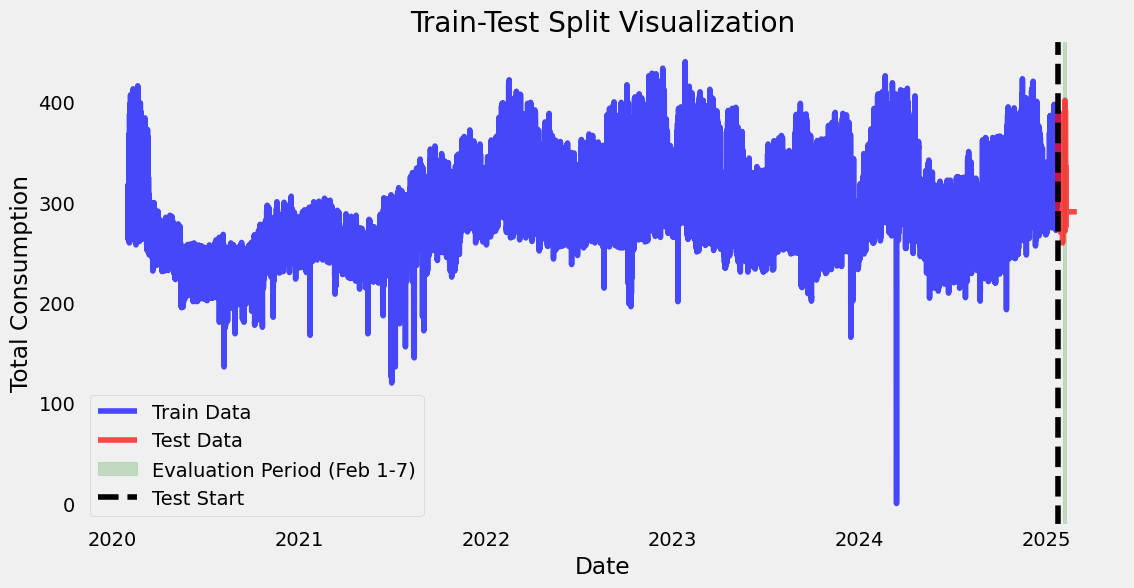

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ensure feature consistency between train and test datasets
def ensure_feature_consistency(train_data, test_data):
    print("Ensuring feature consistency between train and test datasets...")
    
    # Check for differences in columns
    train_cols = set(train_data.columns)
    test_cols = set(test_data.columns)
    
    # Find columns only in train or only in test
    train_only = train_cols - test_cols
    test_only = test_cols - train_cols
    
    print(f"Columns only in train: {train_only}")
    print(f"Columns only in test: {test_only}")
    
    # Create copies to avoid modifying originals
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()
    
    # Add missing columns to train with zero values
    for col in test_only:
        if col != 'Interval End' and col != 'Total Consumption':
            train_data_copy[col] = 0
            print(f"Added column '{col}' to training data")
    
    # Add missing columns to test with zero values
    for col in train_only:
        if col != 'Interval End' and col != 'Total Consumption':
            test_data_copy[col] = 0
            print(f"Added column '{col}' to test data")
    
    # Ensure columns are in the same order
    common_cols = list(set(train_data_copy.columns) & set(test_data_copy.columns))
    
    # Check if 'Interval End' and 'Total Consumption' are in common_cols
    interval_end_in_common = 'Interval End' in common_cols
    total_consumption_in_common = 'Total Consumption' in common_cols
    
    # Rearrange columns to ensure the same order
    cols_to_use = []
    if interval_end_in_common:
        cols_to_use.append('Interval End')
        common_cols.remove('Interval End')
    if total_consumption_in_common:
        cols_to_use.append('Total Consumption')
        common_cols.remove('Total Consumption')
    
    # Add remaining columns (sorted for consistency)
    cols_to_use.extend(sorted(common_cols))
    
    # Reorder columns
    train_data_copy = train_data_copy[cols_to_use]
    test_data_copy = test_data_copy[cols_to_use]
    
    print(f"Final training data shape: {train_data_copy.shape}")
    print(f"Final test data shape: {test_data_copy.shape}")
    
    return train_data_copy, test_data_copy

# Ensure feature consistency first
enhanced_train_data, enhanced_test_data = ensure_feature_consistency(enhanced_train_data, enhanced_test_data)

# Print original shapes
print("Original data shapes:")
print(f"Training data: {enhanced_train_data.shape}")
print(f"Test data: {enhanced_test_data.shape}")

# Set 'Interval End' as index if it's not already
if 'Interval End' in enhanced_train_data.columns:
    enhanced_train_data = enhanced_train_data.set_index('Interval End')
    enhanced_test_data = enhanced_test_data.set_index('Interval End')

# Merge train and test sets
full_data = pd.concat([enhanced_train_data, enhanced_test_data])

# Ensure data is sorted properly
full_data = full_data.sort_index()

# Define split dates as you suggested
test_start = pd.Timestamp('2025-01-23 00:00:00')
test_end = pd.Timestamp('2025-02-28 23:00:00')

# Re-split the data
train_data = full_data[full_data.index < test_start].copy()
test_data = full_data[(full_data.index >= test_start) & (full_data.index <= test_end)].copy()

# Define evaluation period (Feb 1-7, 2025)
eval_start = pd.Timestamp('2025-02-01 00:00:00')
eval_end = pd.Timestamp('2025-02-07 23:00:00')
eval_data = test_data[(test_data.index >= eval_start) & (test_data.index <= eval_end)].copy()

# Print new shapes
print("\nAfter resplitting:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")
print(f"Evaluation data (Feb 1-7): {eval_data.shape}")

# Define X (features) and y (target)
target = 'Total Consumption'
X_train = train_data.drop(columns=[target])
y_train = train_data[target]

X_test = test_data.drop(columns=[target])
y_test = test_data[target]

X_eval = eval_data.drop(columns=[target])
y_eval = eval_data[target]

# Confirm split results
print(f"\nTrain Data Range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test Data Range: {test_data.index.min()} to {test_data.index.max()}")
print(f"Evaluation Period: {eval_data.index.min()} to {eval_data.index.max()}")

# Plot train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, y_train, label='Train Data', color='blue', alpha=0.7)
plt.plot(test_data.index, y_test, label='Test Data', color='red', alpha=0.7)

# Highlight evaluation period
plt.axvspan(eval_start, eval_end, color='green', alpha=0.2, label='Evaluation Period (Feb 1-7)')

# Mark the split date
plt.axvline(test_start, color='black', linestyle='--', label='Test Start')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.grid()

# Show plot
plt.show()

Training sequences shape: (43607, 24, 130)
Testing sequences shape: (864, 24, 130)


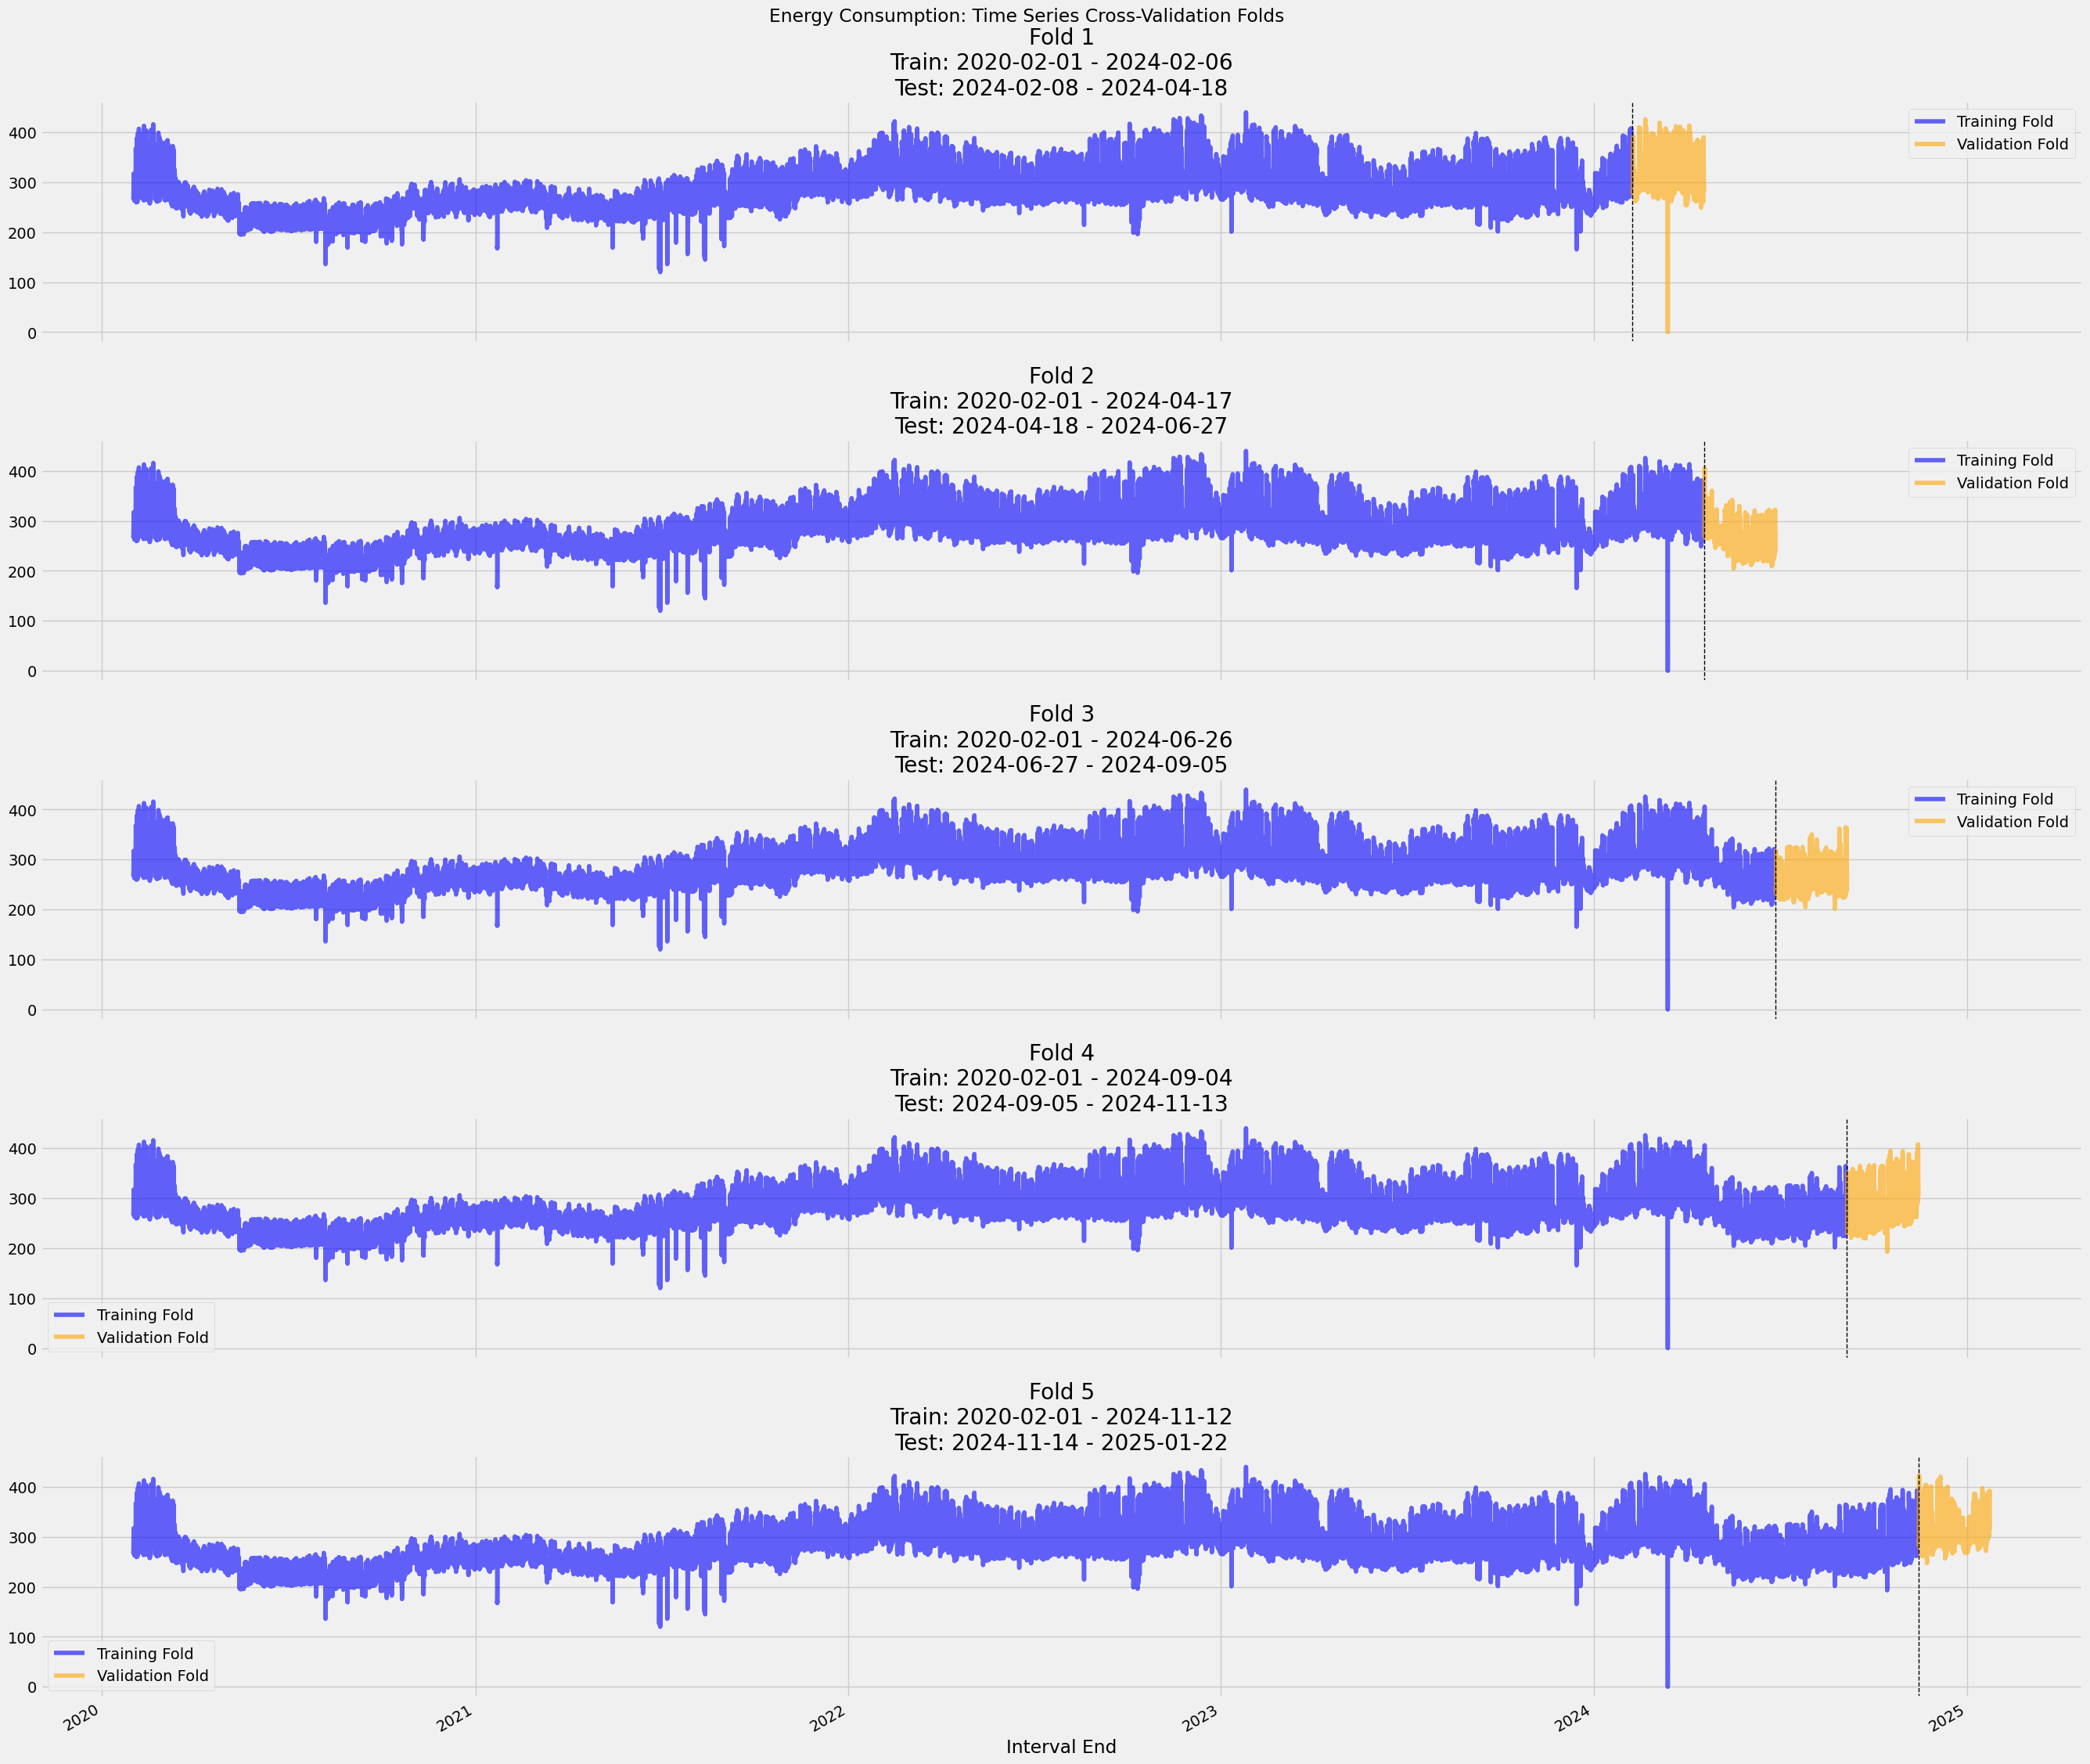


=== Training Random Forest Model ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}

=== Training LSTM Model ===
Epoch 1/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 65s 102ms/step - loss: 0.1266 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 2/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step - loss: 0.0161 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 3/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - loss: 0.0074 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - loss: 0.0046 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 5/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - loss: 0.0035 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 6/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - loss: 0.0029 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 7/100
546/546 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - loss: 0.0

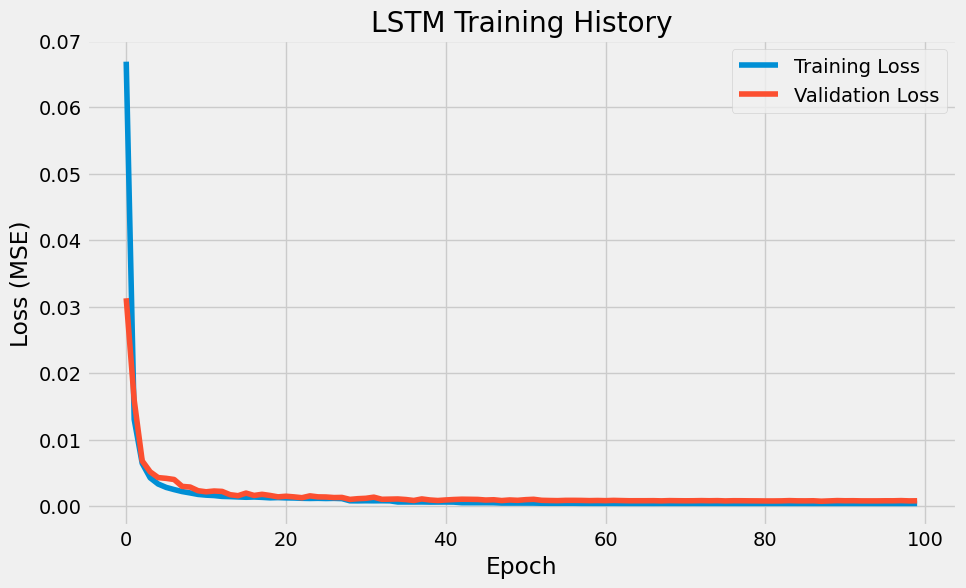

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Evaluation period size: 168
RF predictions for evaluation period: 168
LSTM predictions for evaluation period: 168

=== Evaluation Period Model Performance ===
Random Forest - MAE: 5.20, MSE: 46.90, RMSE: 6.85
LSTM - MAE: 7.22, MSE: 84.53, RMSE: 9.19


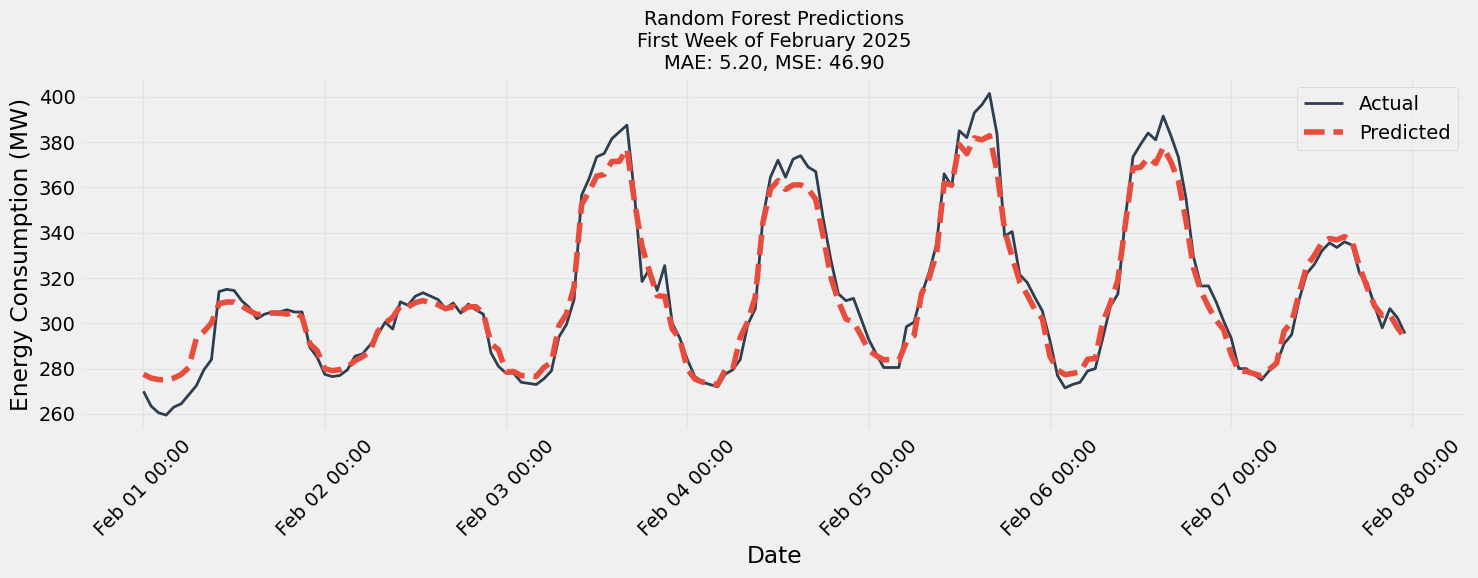

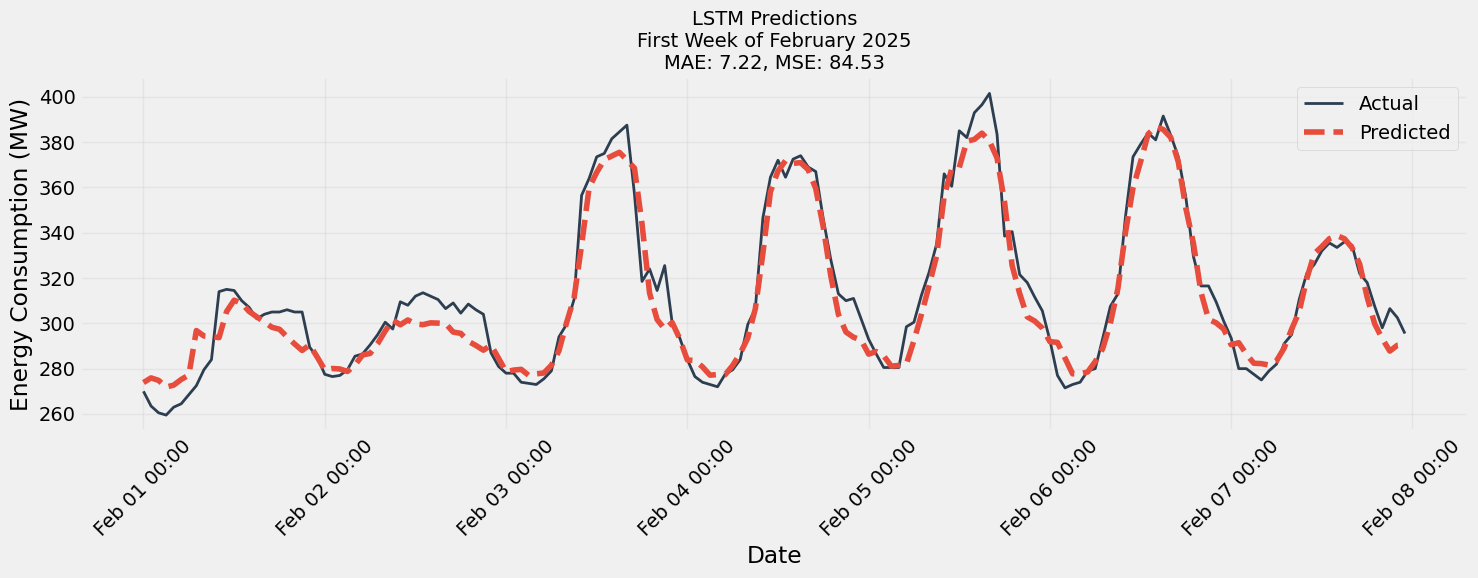


=== Creating Stacking Ensemble ===
Meta-model Linear - MAE: 3.95, MSE: 28.63, RMSE: 5.35
Meta-model Ridge_0.1 - MAE: 3.95, MSE: 28.63, RMSE: 5.35
Meta-model Ridge_1.0 - MAE: 3.95, MSE: 28.63, RMSE: 5.35

Best meta-model: Ridge_1.0 with MAE: 3.95, MSE: 28.63, RMSE: 5.35


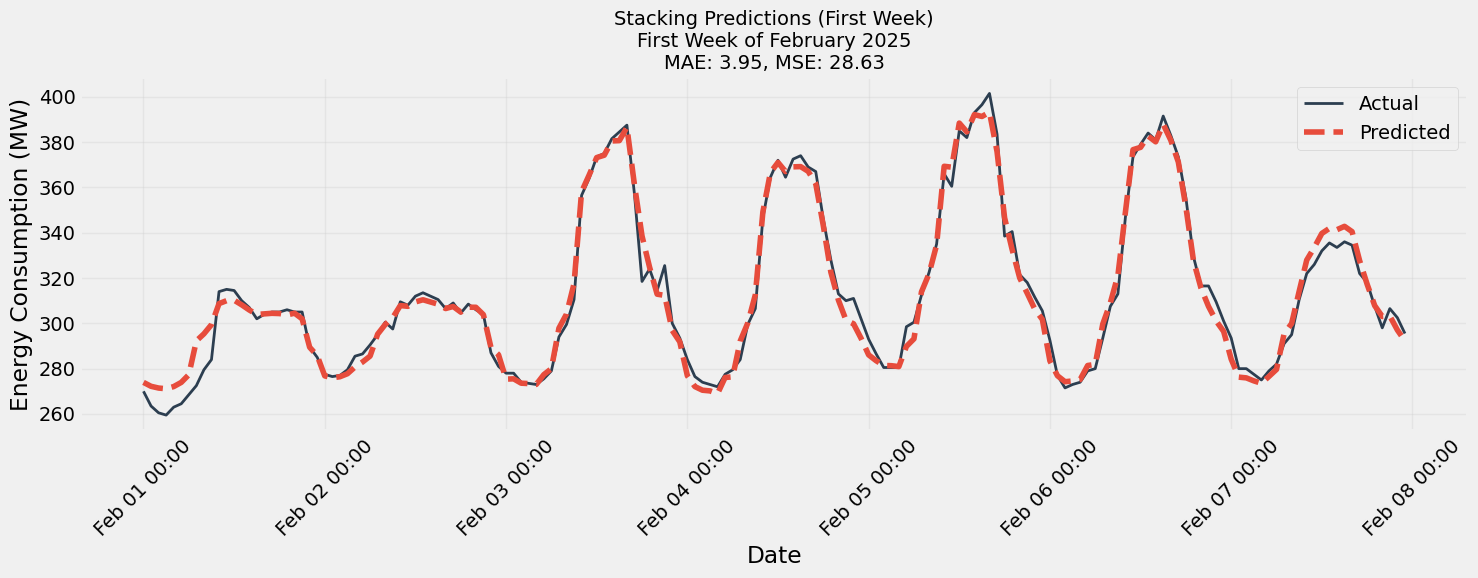


Meta-model coefficients:
          Model  Coefficient
0  RandomForest     1.086574
1          LSTM     0.045089

=== Generating Full February Forecast ===

Forecast saved to February_2025_Forecast.xlsx


In [ ]:
# Initialize separate scalers
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale features and target
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)
X_eval_scaled = scaler_features.transform(X_eval)

y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))
y_eval_scaled = scaler_target.transform(y_eval.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(features_data, target_data, seq_length=24):
    X, y = [], []
    for i in range(len(features_data) - seq_length):
        X.append(features_data[i:i + seq_length])
        y.append(target_data[i + seq_length])  # Predict next hour
    return np.array(X), np.array(y)

seq_length = 24  # 24-hour window

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

n_features = X_train_seq.shape[2]  # Number of features

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Set up proper time series cross-validation for GridSearch
tss = TimeSeriesSplit(n_splits=5, test_size=168*10, gap=24)  # 168 hours = 1 week, gap = 1 day


# Create plot grid with shared x-axis
fig, axs = plt.subplots(5, 1, figsize=(30, 30), sharex=True)
plt.subplots_adjust(hspace=0.4)


# Convert index to datetime if not already
train_data.index = pd.to_datetime(train_data.index)

# Plot each fold using your data columns
fold = 0
for train_idx, val_idx in tss.split(train_data):
    train_fold = train_data.iloc[train_idx]
    test_fold = train_data.iloc[val_idx]
    
    # Plot training fold data
    train_fold['Total Consumption'].plot(
        ax=axs[fold],
        label='Training Fold',
        color='blue',
        alpha=0.6
    )
    
    # Plot validation fold data
    test_fold['Total Consumption'].plot(
        ax=axs[fold],
        label='Validation Fold',
        color='orange',
        alpha=0.6
    )
    
    # Add separation line and annotations
    axs[fold].axvline(test_fold.index.min(), 
                     color='black', 
                     linestyle='--',
                     linewidth=1)
    
    axs[fold].set_title(
        f'Fold {fold+1}\n'
        f'Train: {train_fold.index.date.min()} - {train_fold.index.date.max()}\n'
        f'Test: {test_fold.index.date.min()} - {test_fold.index.date.max()}'
    )
    
    axs[fold].legend()
    fold += 1

# Add main title and format dates
plt.suptitle('Energy Consumption: Time Series Cross-Validation Folds', y=0.92)
fig.autofmt_xdate()
plt.show()


# 1. TRAIN RANDOM FOREST MODEL
print("\n=== Training Random Forest Model ===")

# Define parameter grid for RF
# Hyperparameter Tuning on Optimal Features
param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [20, 30, 40],
    'min_samples_split': [5,10],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Create RF model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# RandomizedSearch with time series cross-validation
# This will be much faster than GridSearch while still exploring the parameter space well
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled (adjust based on your time constraints)
    cv=tss,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit on unscaled data (RF doesn't need scaling)
search.fit(X_train, y_train)

# Get best parameters
print(f"Best RF Parameters: {search.best_params_}")

# Train final model with best parameters
best_rf = search.best_estimator_

# 2. TRAIN LSTM MODEL
print("\n=== Training LSTM Model ===")

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True,
                      kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
                 input_shape=(seq_length, n_features)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True,
                      kernel_regularizer=L1L2(l1=1e-5, l2=1e-4))),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu',
         kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model with EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Split training data into proper train/validation sets
train_end = int(0.8 * len(X_train_seq))
X_train_lstm, X_val_lstm = X_train_seq[:train_end], X_train_seq[train_end:]
y_train_lstm, y_val_lstm = y_train_seq[:train_end], y_train_seq[train_end:]

# Train the model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_lstm, y_val_lstm),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 3. MAKE PREDICTIONS

# Generate RF predictions for all test data
rf_pred_full = best_rf.predict(X_test)
rf_pred_eval = best_rf.predict(X_eval)

# Generate LSTM predictions for test data
lstm_pred_scaled = model.predict(X_test_seq)
lstm_pred_full = scaler_target.inverse_transform(lstm_pred_scaled).flatten()

# Get first week of February test data (evaluation period)
eval_mask = (test_data.index >= eval_start) & (test_data.index <= eval_end)

# We need to find which indices in the LSTM predictions correspond to our evaluation period
# This requires accounting for the sequence length offset
test_dates = test_data.index[seq_length:]  # First valid prediction point for LSTM
lstm_eval_mask = test_dates.isin(eval_data.index)
lstm_pred_eval = lstm_pred_full[lstm_eval_mask]

# Ensure we have the right number of predictions for the evaluation period
print(f"\nEvaluation period size: {len(eval_data)}")
print(f"RF predictions for evaluation period: {len(rf_pred_eval)}")
print(f"LSTM predictions for evaluation period: {len(lstm_pred_eval)}")

# Define the function to plot predictions vs actuals
def plot_predictions(dates, y_true, y_pred, title, mae, mse):
    plt.figure(figsize=(15, 6))
    plt.plot(dates, y_true, label='Actual', color='#2c3e50', linewidth=2)
    plt.plot(dates, y_pred, label='Predicted', linestyle='--', color='#e74c3c')
    plt.title(f'{title}\nFirst Week of February 2025\nMAE: {mae:.2f}, MSE: {mse:.2f}', fontsize=14)
    plt.ylabel('Energy Consumption (MW)')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate metrics for individual models
mae_rf = mean_absolute_error(y_eval, rf_pred_eval)
mse_rf = mean_squared_error(y_eval, rf_pred_eval)
rmse_rf = np.sqrt(mse_rf)

mae_lstm = mean_absolute_error(y_eval, lstm_pred_eval)
mse_lstm = mean_squared_error(y_eval, lstm_pred_eval)
rmse_lstm = np.sqrt(mse_lstm)

print("\n=== Evaluation Period Model Performance ===")
print(f"Random Forest - MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"LSTM - MAE: {mae_lstm:.2f}, MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

# Plot individual model predictions
plot_predictions(eval_data.index, y_eval, rf_pred_eval, 
                 'Random Forest Predictions', mae_rf, mse_rf)
plot_predictions(eval_data.index, y_eval, lstm_pred_eval, 
                 'LSTM Predictions', mae_lstm, mse_lstm)

# 4. STACKING ENSEMBLE
print("\n=== Creating Stacking Ensemble ===")

# Prepare data for stacking (evaluation period)
X_stack = np.column_stack((rf_pred_eval, lstm_pred_eval))
y_stack = y_eval.values

# Try different meta-models
meta_models = {
    'Linear': LinearRegression(),
    'Ridge_0.1': Ridge(alpha=0.1),
    'Ridge_1.0': Ridge(alpha=1.0)
}

best_meta_mae = float('inf')
best_meta_model = None
best_meta_name = None
best_meta_pred = None

for name, model in meta_models.items():
    # Train meta-model
    model.fit(X_stack, y_stack)
    
    # Generate predictions
    meta_pred = model.predict(X_stack)
    
    # Calculate metrics
    meta_mae = mean_absolute_error(y_stack, meta_pred)
    meta_mse = mean_squared_error(y_stack, meta_pred)
    meta_rmse = np.sqrt(meta_mse)
    
    print(f"Meta-model {name} - MAE: {meta_mae:.2f}, MSE: {meta_mse:.2f}, RMSE: {meta_rmse:.2f}")
    
    # Update best model
    if meta_mae < best_meta_mae:
        best_meta_mae = meta_mae
        best_meta_model = model
        best_meta_name = name
        best_meta_pred = meta_pred

# Get the best model's metrics
best_meta_mse = mean_squared_error(y_stack, best_meta_pred)
best_meta_rmse = np.sqrt(best_meta_mse)

print(f"\nBest meta-model: {best_meta_name} with MAE: {best_meta_mae:.2f}, MSE: {best_meta_mse:.2f}, RMSE: {best_meta_rmse:.2f}")

# Plot stacking predictions
plot_predictions(eval_data.index, y_stack, best_meta_pred, 
                 'Stacking Predictions (First Week)', best_meta_mae, best_meta_mse)

# Display meta-model coefficients
if hasattr(best_meta_model, 'coef_'):
    coefs = pd.DataFrame({
        'Model': ['RandomForest', 'LSTM'],
        'Coefficient': best_meta_model.coef_
    })
    print("\nMeta-model coefficients:")
    print(coefs)
    
# 5. GENERATE FULL FEBRUARY FORECAST
print("\n=== Generating Full February Forecast ===")

# Find February data in test set
feb_mask = (test_data.index >= '2025-02-01 00:00') & (test_data.index <= '2025-02-28 23:00')
feb_dates = test_data.index[feb_mask]

# Generate RF predictions for February
rf_pred_feb = best_rf.predict(X_test[feb_mask])

# For LSTM, we need to find which sequences correspond to February dates
# First find all valid prediction dates (considering sequence length)
lstm_valid_dates = test_data.index[seq_length:]
lstm_feb_mask = lstm_valid_dates.isin(feb_dates)
lstm_pred_feb = lstm_pred_full[lstm_feb_mask]

# Align dates for stacking
common_dates = lstm_valid_dates[lstm_feb_mask]
rf_pred_aligned = np.array([rf_pred_feb[feb_dates.get_loc(date)] for date in common_dates])

# Create stacking input
X_stack_feb = np.column_stack((rf_pred_aligned, lstm_pred_feb))

# Generate stacked predictions for February
stacked_pred_feb = best_meta_model.predict(X_stack_feb)

# Create forecast DataFrame without actual values
forecast_df = pd.DataFrame({
    'Interval End': common_dates,
    'RF_Prediction': rf_pred_aligned,
    'LSTM_Prediction': lstm_pred_feb,
    'Stacking_Prediction': stacked_pred_feb
}).round(1)  # Round to 1 decimal place

# Save to Excel
forecast_df.to_excel('February_2025_Forecast.xlsx', index=False)

print("\nForecast saved to February_2025_Forecast.xlsx")